In [97]:
import pandas as pd 

In [99]:
dataframe = pd.read_csv('cleaned_data.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3192 non-null   object 
 1   Time           3192 non-null   object 
 2   Comp           3192 non-null   object 
 3   Round          3192 non-null   object 
 4   Day            3192 non-null   object 
 5   Venue          3192 non-null   object 
 6   Result         3192 non-null   object 
 7   GF             3192 non-null   int64  
 8   GA             3192 non-null   int64  
 9   Opponent       3192 non-null   object 
 10  xG             3192 non-null   float64
 11  xGA            3192 non-null   float64
 12  Poss           3192 non-null   float64
 13  Attendance     2486 non-null   float64
 14  Formation      3192 non-null   object 
 15  Opp Formation  3192 non-null   object 
 16  Gls            3192 non-null   int64  
 17  Sh             3192 non-null   float64
 18  SoT%    

normalisation des equipes

In [102]:
teams = dataframe['Team'].unique()
opponents = dataframe['Opponent'].unique()

print("Équipes :", teams)
print("Adversaires :", opponents)

Équipes : ['Manchester City' 'Arsenal' 'Liverpool' 'Aston Villa' 'Tottenham Hotspur'
 'Chelsea' 'Newcastle United' 'Manchester United' 'West Ham United'
 'Crystal Palace' 'Brighton and Hove Albion' 'Bournemouth' 'Fulham'
 'Wolverhampton Wanderers' 'Everton' 'Brentford' 'Nottingham Forest'
 'Luton Town' 'Burnley' 'Sheffield United']
Adversaires : ['West Ham' 'Tottenham' 'Bournemouth' 'Brighton' 'Norwich City' 'Watford'
 'Everton' 'Wolves' 'Crystal Palace' 'Aston Villa' 'Southampton'
 'Liverpool' 'Chelsea' 'Newcastle Utd' 'Burnley' 'Manchester Utd'
 'Arsenal' 'Leicester City' 'Sheffield Utd' 'Leeds United' 'Fulham'
 'West Brom' 'Brentford' "Nott'ham Forest" 'Luton Town' 'Manchester City']


In [104]:
# Dictionnaire de correspondance pour normaliser les noms
normalization_dict = {
    'Manchester City': 'Manchester City',
    'Arsenal': 'Arsenal',
    'Liverpool': 'Liverpool',
    'Aston Villa': 'Aston Villa',
    'Tottenham Hotspur': 'Tottenham',
    'Tottenham': 'Tottenham',
    'Chelsea': 'Chelsea',
    'Newcastle United': 'Newcastle',
    'Newcastle Utd': 'Newcastle',
    'Manchester United': 'Manchester United',
    'Manchester Utd': 'Manchester United',
    'West Ham United': 'West Ham',
    'West Ham': 'West Ham',
    'Crystal Palace': 'Crystal Palace',
    'Brighton and Hove Albion': 'Brighton',
    'Brighton': 'Brighton',
    'Bournemouth': 'Bournemouth',
    'Fulham': 'Fulham',
    'Wolverhampton Wanderers': 'Wolves',
    'Wolves': 'Wolves',
    'Everton': 'Everton',
    'Brentford': 'Brentford',
    'Nottingham Forest': "Nottingham Forest",
    "Nott'ham Forest": "Nottingham Forest",
    'Luton Town': 'Luton Town',
    'Burnley': 'Burnley',
    'Sheffield United': 'Sheffield Utd',
    'Sheffield Utd': 'Sheffield Utd',
    'Southampton': 'Southampton',
    'Leeds United': 'Leeds',
    'Leicester City': 'Leicester',
    'West Brom': 'West Brom',
    'Norwich City': 'Norwich',
    'Watford': 'Watford'
}

# Fonction pour normaliser les noms
def normalize_names(name):
    return normalization_dict.get(name, name)

# Appliquer la normalisation aux colonnes "Team" et "Opponent"
dataframe['Team'] = dataframe['Team'].apply(normalize_names)
dataframe['Opponent'] = dataframe['Opponent'].apply(normalize_names)

# Vérifier les résultats
teams = dataframe['Team'].unique()
opponents = dataframe['Opponent'].unique()

print("Équipes normalisées :", teams)
print("Adversaires normalisés :", opponents)


Équipes normalisées : ['Manchester City' 'Arsenal' 'Liverpool' 'Aston Villa' 'Tottenham'
 'Chelsea' 'Newcastle' 'Manchester United' 'West Ham' 'Crystal Palace'
 'Brighton' 'Bournemouth' 'Fulham' 'Wolves' 'Everton' 'Brentford'
 'Nottingham Forest' 'Luton Town' 'Burnley' 'Sheffield Utd']
Adversaires normalisés : ['West Ham' 'Tottenham' 'Bournemouth' 'Brighton' 'Norwich' 'Watford'
 'Everton' 'Wolves' 'Crystal Palace' 'Aston Villa' 'Southampton'
 'Liverpool' 'Chelsea' 'Newcastle' 'Burnley' 'Manchester United' 'Arsenal'
 'Leicester' 'Sheffield Utd' 'Leeds' 'Fulham' 'West Brom' 'Brentford'
 'Nottingham Forest' 'Luton Town' 'Manchester City']


prediction 

In [107]:
import numpy as np 
from scipy.stats import poisson
from sklearn.linear_model import PoissonRegressor 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [109]:
def optimize_rmse_per_team_with_importance_by_venue(df, n_range, alpha_values):
    """
    Trouver les meilleurs paramètres (n, alpha) pour chaque équipe 
    et chaque type de match (domicile et extérieur), et afficher uniquement les RMSE.
    
    Arguments :
        df : DataFrame contenant les données.
        n_range : Plage des valeurs pour n (fenêtre pour Last_n_Goals).
        alpha_values : Liste des valeurs d'alpha (régularisation du modèle).
    
    Retourne :
        Un dictionnaire contenant les meilleurs RMSE pour chaque équipe et lieu.
    """
    best_rmse_per_team = {}

    # Diviser la DataFrame par équipes
    teams = df['Team'].unique()
    
    for team in teams:
        best_rmse_per_team[team] = {}  # Stocker les RMSE pour Home et Away

        for venue in ['Home', 'Away']:
            # Filtrer les données pour l'équipe et le lieu
            team_data = df[(df['Team'] == team) & (df['Venue'] == venue)].copy()
            
            # Initialiser le meilleur RMSE à une valeur infinie
            best_rmse = float('inf')

            # Explorer toutes les combinaisons de paramètres
            for n in n_range:
                # Calculer les moyennes mobiles pour Last_n_Goals (moyenne des buts marqués)
                team_data['Last_n_Goals'] = team_data['GF'].rolling(n, min_periods=1).mean().shift(1)

                # Mettre à jour les features
                X = team_data[['Last_n_Goals']]
                
                # Imputer les valeurs manquantes
                imputer = SimpleImputer(strategy='mean')
                X = imputer.fit_transform(X)
                
                # Supprimer les NaN dans la cible
                team_data = team_data.dropna(subset=['GF'])
                y = team_data['GF']
                
                # Diviser les données
                if len(team_data) < 2:  # Si les données sont insuffisantes, passer à la prochaine équipe
                    continue
                
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                
                for alpha in alpha_values:
                    # Entraîner le modèle
                    model = PoissonRegressor(alpha=alpha)
                    model.fit(X_train, y_train)
                    
                    # Faire des prédictions
                    predictions = model.predict(X_test)
                    
                    # Calculer le RMSE
                    mse = mean_squared_error(y_test, predictions)
                    rmse = np.sqrt(mse)
                    
                    # Vérifier si c'est le meilleur RMSE
                    if rmse < best_rmse:
                        best_rmse = rmse

            # Stocker le meilleur RMSE pour cette équipe et lieu
            best_rmse_per_team[team][venue] = best_rmse

    return best_rmse_per_team


In [111]:
# Exemple de plages de paramètres
n_range = range(1, 3)  # Par exemple, pour n allant de 1 à 5
alpha_values = [0.1]  # Valeurs d'alpha pour la régularisation

# Appeler la fonction pour optimiser les paramètres et obtenir les résultats
best_rmse = optimize_rmse_per_team_with_importance_by_venue(dataframe, n_range, alpha_values)

# Afficher les RMSE pour chaque équipe et lieu
for team, team_results in best_rmse.items():
    print(f"Team: {team}")
    
    for venue, rmse in team_results.items():
        print(f"  Venue: {venue} | Best RMSE: {rmse:.4f}")

Team: Manchester City
  Venue: Home | Best RMSE: 1.7702
  Venue: Away | Best RMSE: 1.6680
Team: Arsenal
  Venue: Home | Best RMSE: 1.3184
  Venue: Away | Best RMSE: 1.3583
Team: Liverpool
  Venue: Home | Best RMSE: 1.3281
  Venue: Away | Best RMSE: 1.5690
Team: Aston Villa
  Venue: Home | Best RMSE: 0.7463
  Venue: Away | Best RMSE: 0.8949
Team: Tottenham
  Venue: Home | Best RMSE: 1.0992
  Venue: Away | Best RMSE: 1.1524
Team: Chelsea
  Venue: Home | Best RMSE: 1.7152
  Venue: Away | Best RMSE: 1.2050
Team: Newcastle
  Venue: Home | Best RMSE: 1.3428
  Venue: Away | Best RMSE: 1.3476
Team: Manchester United
  Venue: Home | Best RMSE: 1.6129
  Venue: Away | Best RMSE: 1.0423
Team: West Ham
  Venue: Home | Best RMSE: 0.9546
  Venue: Away | Best RMSE: 1.5293
Team: Crystal Palace
  Venue: Home | Best RMSE: 1.3136
  Venue: Away | Best RMSE: 0.9107
Team: Brighton
  Venue: Home | Best RMSE: 1.2480
  Venue: Away | Best RMSE: 1.1924
Team: Bournemouth
  Venue: Home | Best RMSE: 0.9313
  Venue: 

In [113]:
# Initialisation pour accumuler la somme de tous les RMSE
total_rmse = 0
total_count = 0  # Compteur pour suivre combien de RMSE sont ajoutés

# Parcours de chaque équipe et venue pour accumuler les RMSE
for team, team_results in best_rmse.items():
    print(f"Team: {team}")
    
    for venue, rmse in team_results.items():
        print(f"  Venue: {venue} | Best RMSE: {rmse:.4f}")
        
        # Accumuler le RMSE
        total_rmse += rmse
        total_count += 1

# Calcul du RMSE global en divisant la somme des RMSE par le nombre total de calculs
global_rmse = total_rmse / total_count
print(f"\nGlobal RMSE for the model: {global_rmse:.4f}")


Team: Manchester City
  Venue: Home | Best RMSE: 1.7702
  Venue: Away | Best RMSE: 1.6680
Team: Arsenal
  Venue: Home | Best RMSE: 1.3184
  Venue: Away | Best RMSE: 1.3583
Team: Liverpool
  Venue: Home | Best RMSE: 1.3281
  Venue: Away | Best RMSE: 1.5690
Team: Aston Villa
  Venue: Home | Best RMSE: 0.7463
  Venue: Away | Best RMSE: 0.8949
Team: Tottenham
  Venue: Home | Best RMSE: 1.0992
  Venue: Away | Best RMSE: 1.1524
Team: Chelsea
  Venue: Home | Best RMSE: 1.7152
  Venue: Away | Best RMSE: 1.2050
Team: Newcastle
  Venue: Home | Best RMSE: 1.3428
  Venue: Away | Best RMSE: 1.3476
Team: Manchester United
  Venue: Home | Best RMSE: 1.6129
  Venue: Away | Best RMSE: 1.0423
Team: West Ham
  Venue: Home | Best RMSE: 0.9546
  Venue: Away | Best RMSE: 1.5293
Team: Crystal Palace
  Venue: Home | Best RMSE: 1.3136
  Venue: Away | Best RMSE: 0.9107
Team: Brighton
  Venue: Home | Best RMSE: 1.2480
  Venue: Away | Best RMSE: 1.1924
Team: Bournemouth
  Venue: Home | Best RMSE: 0.9313
  Venue: 

In [115]:
def add_optimal_rmse_predictions(df, n_range, alpha_values):
    """
    Ajouter une colonne au DataFrame contenant les prédictions optimales
    (pour chaque ligne en fonction de l'équipe et du lieu).
    
    Arguments :
        df : DataFrame contenant les données.
        n_range : Plage des valeurs pour n (fenêtre pour Last_n_Goals).
        alpha_values : Liste des valeurs d'alpha (régularisation du modèle).
    
    Retourne :
        Le DataFrame original avec une nouvelle colonne 'Optimal_Predictions'.
    """
    # Créer une colonne pour stocker les prédictions
    df['Optimal_Predictions'] = np.nan

    # Diviser la DataFrame par équipes
    teams = df['Team'].unique()
    
    for team in teams:
        for venue in ['Home', 'Away']:
            # Filtrer les données pour l'équipe et le lieu
            team_data = df[(df['Team'] == team) & (df['Venue'] == venue)].copy()

            if team_data.empty:
                continue
            
            # Initialiser les meilleurs paramètres
            best_model = None
            best_rmse = float('inf')
            best_n = None
            
            for n in n_range:
                # Calculer les moyennes mobiles pour Last_n_Goals
                team_data['Last_n_Goals'] = team_data['GF'].rolling(n, min_periods=1).mean().shift(1)

                # Mettre à jour les features
                X = team_data[['Last_n_Goals']]
                
                # Imputer les valeurs manquantes
                imputer = SimpleImputer(strategy='mean')
                X = imputer.fit_transform(X)
                
                # Supprimer les NaN dans la cible
                team_data = team_data.dropna(subset=['GF'])
                y = team_data['GF']
                
                # Diviser les données
                if len(team_data) < 2:  # Ignorer si insuffisant
                    continue
                
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                
                for alpha in alpha_values:
                    # Entraîner le modèle
                    model = PoissonRegressor(alpha=alpha)
                    model.fit(X_train, y_train)
                    
                    # Faire des prédictions
                    predictions = model.predict(X_test)
                    
                    # Calculer le RMSE
                    mse = mean_squared_error(y_test, predictions)
                    rmse = np.sqrt(mse)
                    
                    # Vérifier si c'est le meilleur modèle
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = model
                        best_n = n
            
            # Appliquer le meilleur modèle pour l'équipe et le lieu
            if best_model is not None and best_n is not None:
                team_data['Last_n_Goals'] = team_data['GF'].rolling(best_n, min_periods=1).mean().shift(1)
                X_all = imputer.fit_transform(team_data[['Last_n_Goals']])
                optimal_predictions = best_model.predict(X_all)

                # Insérer les prédictions dans la colonne 'Optimal_Predictions' du DataFrame original
                df.loc[(df['Team'] == team) & (df['Venue'] == venue), 'Optimal_Predictions'] = optimal_predictions
    
    return df


In [117]:
# Appeler la fonction pour ajouter la colonne des prédictions optimales
n_range = range(1, 20)  # Par exemple, tester des moyennes mobiles de 5 à 10 matchs
alpha_values = [0.1]

# Ajouter la colonne au DataFrame
df_with_predictions = add_optimal_rmse_predictions(dataframe, n_range, alpha_values)

# Vérifier le résultat
print(df_with_predictions[['Team', 'Venue', 'GF', 'Optimal_Predictions']].head(20))


               Team Venue  GF  Optimal_Predictions
0   Manchester City  Away   5             2.062410
1   Manchester City  Home   2             2.856620
2   Manchester City  Away   3             1.375777
3   Manchester City  Home   4             2.840600
4   Manchester City  Away   2             1.588581
5   Manchester City  Home   8             2.879367
6   Manchester City  Away   3             1.748439
7   Manchester City  Home   0             2.958497
8   Manchester City  Away   2             1.769520
9   Manchester City  Home   3             2.802354
10  Manchester City  Home   2             2.859918
11  Manchester City  Away   1             1.834302
12  Manchester City  Home   2             2.840600
13  Manchester City  Away   2             1.924382
14  Manchester City  Away   4             1.950923
15  Manchester City  Home   1             2.840600
16  Manchester City  Away   3             1.991421
17  Manchester City  Home   3             2.821412
18  Manchester City  Away   2  

In [118]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 3192 non-null   object 
 1   Time                 3192 non-null   object 
 2   Comp                 3192 non-null   object 
 3   Round                3192 non-null   object 
 4   Day                  3192 non-null   object 
 5   Venue                3192 non-null   object 
 6   Result               3192 non-null   object 
 7   GF                   3192 non-null   int64  
 8   GA                   3192 non-null   int64  
 9   Opponent             3192 non-null   object 
 10  xG                   3192 non-null   float64
 11  xGA                  3192 non-null   float64
 12  Poss                 3192 non-null   float64
 13  Attendance           2486 non-null   float64
 14  Formation            3192 non-null   object 
 15  Opp Formation        3192 non-null   o

In [119]:
# Efficacité offensive excluant le match actuel
dataframe['Rolling_Eff_Off'] = (
    dataframe.groupby('Team')
    .apply(lambda group: (group['GF'] / group['xG'])  # Calcul de l'efficacité offensive
           .rolling(window=5, min_periods=1)  # Moyenne glissante sur 10 matchs
           .mean()
           .shift(1))  # Décale pour exclure le match actuel
    .reset_index(level=0, drop=True)  # Réinitialiser l'index pour le DataFrame d'origine
)

# Efficacité défensive excluant le match actuel
dataframe['Rolling_Eff_Def'] = (
    dataframe.groupby('Team')
    .apply(lambda group: (group['xGA'] / group['GA'])  # Calcul de l'efficacité défensive
           .rolling(window=5, min_periods=1)  # Moyenne glissante sur 10 matchs
           .mean()
           .shift(1))  # Décale pour exclure le match actuel
    .reset_index(level=0, drop=True)  # Réinitialiser l'index pour le DataFrame d'origine
)

# Remplacer les NaN par la moyenne de chaque colonne
dataframe['Rolling_Eff_Off'] = dataframe['Rolling_Eff_Off'].fillna(dataframe['Rolling_Eff_Off'].mean())
dataframe['Rolling_Eff_Def'] = dataframe['Rolling_Eff_Def'].fillna(dataframe['Rolling_Eff_Def'].mean())

# Afficher un aperçu
print(dataframe[['Team', 'GF', 'xG', 'GA', 'xGA', 'Rolling_Eff_Off', 'Rolling_Eff_Def']].head())


              Team  GF   xG  GA  xGA  Rolling_Eff_Off  Rolling_Eff_Def
0  Manchester City   5  3.2   0  1.1         1.090481         0.941777
1  Manchester City   2  2.9   2  0.1         1.562500         0.941777
2  Manchester City   3  3.0   1  2.2         1.126078         0.050000
3  Manchester City   4  1.9   0  0.9         1.084052         1.125000
4  Manchester City   2  2.3   3  1.5         1.339355         1.125000


C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\3192083131.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['GF'] / group['xG'])  # Calcul de l'efficacité offensive
C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\3192083131.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: (group['xGA'] / group['GA'])  # Calcul de l'efficacité défensive


In [120]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 3192 non-null   object 
 1   Time                 3192 non-null   object 
 2   Comp                 3192 non-null   object 
 3   Round                3192 non-null   object 
 4   Day                  3192 non-null   object 
 5   Venue                3192 non-null   object 
 6   Result               3192 non-null   object 
 7   GF                   3192 non-null   int64  
 8   GA                   3192 non-null   int64  
 9   Opponent             3192 non-null   object 
 10  xG                   3192 non-null   float64
 11  xGA                  3192 non-null   float64
 12  Poss                 3192 non-null   float64
 13  Attendance           2486 non-null   float64
 14  Formation            3192 non-null   object 
 15  Opp Formation        3192 non-null   o

In [121]:
dataframe['Win_NotWin'] = (dataframe['Result'] == 'W').astype(int)
dataframe['Win_NotWin'].head(10)

0    1
1    0
2    1
3    1
4    0
5    1
6    1
7    0
8    1
9    1
Name: Win_NotWin, dtype: int32

In [122]:
# Remplacer les valeurs "Home" et "Away" par 1 et 0 respectivement dans la colonne "Venue"
dataframe['Venue'] = dataframe['Venue'].replace({'Home': 1, 'Away': 0})

# Vérification des résultats
print(dataframe[['Team', 'Opponent', 'Venue']].head())


              Team     Opponent  Venue
0  Manchester City     West Ham      0
1  Manchester City    Tottenham      1
2  Manchester City  Bournemouth      0
3  Manchester City     Brighton      1
4  Manchester City      Norwich      0


C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\1219213190.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe['Venue'] = dataframe['Venue'].replace({'Home': 1, 'Away': 0})


In [123]:

home_wins = dataframe[dataframe["Venue"] == 1].groupby("Team")["Win_NotWin"].mean().reset_index()
home_wins.columns = ["Team", "avg_win_home"]

# Calculer les moyennes des victoires à l'extérieur
away_wins = dataframe[dataframe["Venue"] == 0].groupby("Team")["Win_NotWin"].mean().reset_index()
away_wins.columns = ["Team", "avg_win_away"]

# Fusionner les moyennes dans un seul DataFrame
team_stats = pd.merge(home_wins, away_wins, on="Team", how="outer").fillna(0)

# Afficher les résultats
print(team_stats)

                 Team  avg_win_home  avg_win_away
0             Arsenal      0.631579      0.505263
1         Aston Villa      0.463158      0.336842
2         Bournemouth      0.315789      0.263158
3           Brentford      0.385965      0.280702
4            Brighton      0.336842      0.294737
5             Burnley      0.250000      0.236842
6             Chelsea      0.484211      0.452632
7      Crystal Palace      0.357895      0.252632
8             Everton      0.389474      0.263158
9              Fulham      0.333333      0.245614
10          Liverpool      0.747368      0.547368
11         Luton Town      0.210526      0.105263
12    Manchester City      0.778947      0.673684
13  Manchester United      0.568421      0.442105
14          Newcastle      0.452632      0.315789
15  Nottingham Forest      0.342105      0.131579
16      Sheffield Utd      0.298246      0.122807
17          Tottenham      0.631579      0.357895
18           West Ham      0.421053      0.315789


In [131]:
import pandas as pd

# Exemple de DataFrame pour `dataframe` et `team_stats`
# dataframe = pd.read_csv("votre_data.csv")  # Remplacez par votre propre DataFrame
# team_stats = pd.read_csv("team_stats.csv")  # Remplacez par votre propre DataFrame

# 1. Vérifier les colonnes dans team_stats
print(team_stats.columns)  # Affiche les colonnes pour s'assurer que `avg_win_home` et `avg_win_away` existent

# 2. Fusionner les statistiques des équipes avec dataframe
dataframe = pd.merge(dataframe, team_stats, on="Team", how="left")

# 3. Vérification de la colonne Venue (1 = domicile, 0 = extérieur)
print(dataframe['Venue'].value_counts())  # Vérifiez que les valeurs de Venue sont correctes

# 4. Encoder Team selon le contexte (domicile/extérieur)
dataframe["encoded_team"] = dataframe.apply(
    lambda row: row["avg_win_home"] if row["Venue"] == 1 else row["avg_win_away"],
    axis=1
)

# 5. Fusionner les statistiques des adversaires (renommer les colonnes)
opponent_stats = team_stats.rename(
    columns={
        "Team": "Opponent",
        "avg_win_home": "opponent_avg_home",
        "avg_win_away": "opponent_avg_away"
    }
)

# 6. Fusionner les données des adversaires avec dataframe
dataframe = pd.merge(dataframe, opponent_stats, left_on="Opponent", right_on="Opponent", how="left")

# 7. Encoder Opponent selon le contexte (domicile/extérieur de l'adversaire)
dataframe["encoded_opponent"] = dataframe.apply(
    lambda row: row["opponent_avg_away"] if row["Venue"] == 1 else row["opponent_avg_home"],
    axis=1
)

# 8. Nettoyer le DataFrame en supprimant les colonnes intermédiaires
dataframe = dataframe.drop(columns=["avg_win_home", "avg_win_away", "opponent_avg_home", "opponent_avg_away"])

# 9. Vérification du résultat
print(dataframe.head())


Index(['Team', 'avg_win_home', 'avg_win_away'], dtype='object')
Venue
0    1596
1    1596
Name: count, dtype: int64
         Date   Time            Comp        Round  Day  Venue Result  GF  GA  \
0  2019-08-10  12:30  Premier League  Matchweek 1  Sat      0      W   5   0   
1  2019-08-17  17:30  Premier League  Matchweek 2  Sat      1      D   2   2   
2  2019-08-25  14:00  Premier League  Matchweek 3  Sun      0      W   3   1   
3  2019-08-31  15:00  Premier League  Matchweek 4  Sat      1      W   4   0   
4  2019-09-14  17:30  Premier League  Matchweek 5  Sat      0      L   2   3   

      Opponent  ...   FK  PK     Season             Team Optimal_Predictions  \
0     West Ham  ...  0.0   1  2019-2020  Manchester City            2.062410   
1    Tottenham  ...  0.0   0  2019-2020  Manchester City            2.856620   
2  Bournemouth  ...  0.0   0  2019-2020  Manchester City            1.375777   
3     Brighton  ...  1.0   0  2019-2020  Manchester City            2.840600   
4  

In [133]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 3192 non-null   object 
 1   Time                 3192 non-null   object 
 2   Comp                 3192 non-null   object 
 3   Round                3192 non-null   object 
 4   Day                  3192 non-null   object 
 5   Venue                3192 non-null   int64  
 6   Result               3192 non-null   object 
 7   GF                   3192 non-null   int64  
 8   GA                   3192 non-null   int64  
 9   Opponent             3192 non-null   object 
 10  xG                   3192 non-null   float64
 11  xGA                  3192 non-null   float64
 12  Poss                 3192 non-null   float64
 13  Attendance           2486 non-null   float64
 14  Formation            3192 non-null   object 
 15  Opp Formation        3192 non-null   o

In [135]:
# Remplacer les valeurs manquantes dans la colonne 'encoded_opponent' par 0.1
dataframe['encoded_opponent'] = dataframe['encoded_opponent'].fillna(0.1)

# Vérification
print(dataframe[['encoded_opponent']].head())


   encoded_opponent
0          0.421053
1          0.357895
2          0.315789
3          0.294737
4          0.100000


In [137]:
from sklearn.preprocessing import MinMaxScaler

# Initialisation du scaler
scaler = MinMaxScaler()

# Remplacement des valeurs NaN dans 'Attendance' par 0 (par exemple, pour les matchs à huis clos)
dataframe['Attendance'] = dataframe['Attendance'].fillna(0)

# Normalisation de la colonne 'Attendance' entre 0 et 1
dataframe['Attendance_Normalized'] = scaler.fit_transform(dataframe[['Attendance']])

# Définir les équipes du top 5
top_5_teams = ['manchester city', 'liverpool', 'arsenal', 'manchester united', 'chelsea']

# Appliquer la normalisation avec les règles spécifiées
dataframe['Attendance_Normalized'] = dataframe.apply(
    lambda row: row['Attendance_Normalized'] 
                if row['Team'].lower() in top_5_teams 
                else (row['Attendance_Normalized'] if row['Venue'] == 1 else -row['Attendance_Normalized']), 
    axis=1
)

# Vérification des résultats
print(dataframe[['Team', 'Attendance', 'Venue', 'Attendance_Normalized']].head())


              Team  Attendance  Venue  Attendance_Normalized
0  Manchester City     59870.0      0               0.792497
1  Manchester City     54503.0      1               0.721454
2  Manchester City     10486.0      0               0.138803
3  Manchester City     54386.0      1               0.719906
4  Manchester City     27035.0      0               0.357861


In [139]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   3192 non-null   object 
 1   Time                   3192 non-null   object 
 2   Comp                   3192 non-null   object 
 3   Round                  3192 non-null   object 
 4   Day                    3192 non-null   object 
 5   Venue                  3192 non-null   int64  
 6   Result                 3192 non-null   object 
 7   GF                     3192 non-null   int64  
 8   GA                     3192 non-null   int64  
 9   Opponent               3192 non-null   object 
 10  xG                     3192 non-null   float64
 11  xGA                    3192 non-null   float64
 12  Poss                   3192 non-null   float64
 13  Attendance             3192 non-null   float64
 14  Formation              3192 non-null   object 
 15  Opp 

In [141]:
# Séparation des données en train et test
train_data = dataframe[dataframe['Season'].isin(['2019-2020', '2020-2021', '2021-2022'])]  # Données d'entraînement
test_data = dataframe[dataframe['Season'] == '2022-2023']  # Données de test pour la saison 2022-2023

# Sélection des features et de la cible pour l'entraînement
X_train = train_data[['encoded_team', 'encoded_opponent', 'Optimal_Predictions',  
                     'Rolling_Eff_Off' , 'Rolling_Eff_Def' , 'Attendance_Normalized']]
y_train = train_data['Win_NotWin']

# Sélection des features az de la cible pour le test
X_test = test_data[['encoded_team', 'encoded_opponent', 'Optimal_Predictions',  
                     'Rolling_Eff_Off' , 'Rolling_Eff_Def' , 'Attendance_Normalized']]
y_test = test_data['Win_NotWin']

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Meilleurs paramètres : {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6455
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       375
           1       0.61      0.42      0.50       271

    accuracy                           0.65       646
   macro avg       0.64      0.61      0.61       646
weighted avg       0.64      0.65      0.63       646



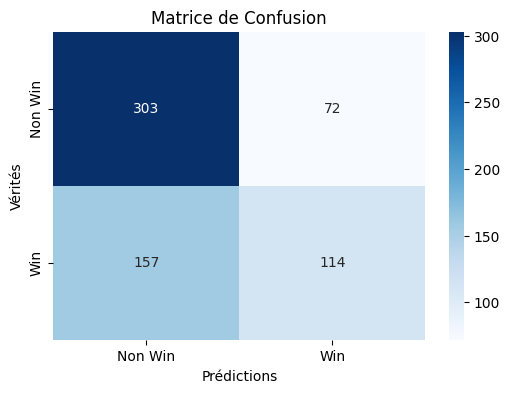

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'max_depth': [10, 20, 30, None],  # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4],    # Nombre minimum d'échantillons pour être dans un noeud terminal
    'max_features': ['sqrt', 'log2', None],  # Nombre maximum de caractéristiques à considérer
    'bootstrap': [True, False]        # Si l'échantillonnage avec remise est utilisé
}

# Initialisation du modèle Random Forest
rf = RandomForestClassifier(random_state=42)

# Initialisation de GridSearchCV
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5,               # Validation croisée
                           n_jobs=-1,          # Utilise tous les cœurs disponibles
                           verbose=2,          # Affiche la progression
                           scoring='accuracy') # Métrique utilisée pour évaluer

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Utiliser le meilleur modèle trouvé
best_rf_model = grid_search.best_estimator_

# Prédictions sur le jeu de test
y_pred = best_rf_model.predict(X_test)

# Calcul de l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Affichage du rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion avec Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non Win', 'Win'], 
            yticklabels=['Non Win', 'Win'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()


In [64]:
#plot_confusion_matrix(best_rf_model, X_test, y_test)
test_accuracy = best_rf_model.score(X_train, y_train)
test_accuracy

0.8331466965285554

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fi

Meilleurs paramètres : {'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Accuracy: 0.6765
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.82      0.75       375
           1       0.66      0.47      0.55       271

    accuracy                           0.68       646
   macro avg       0.67      0.65      0.65       646
weighted avg       0.67      0.68      0.66       646



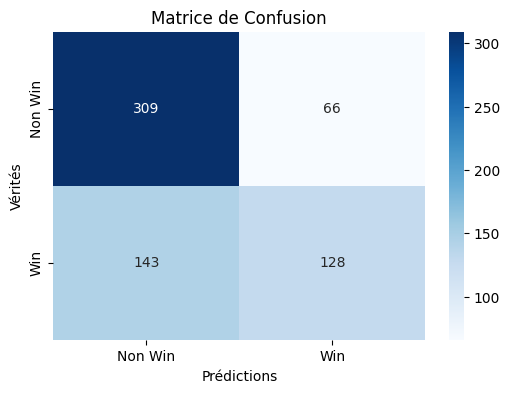

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement pour imputer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')

# Grille des hyperparamètres à tester
param_grid = {
    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga'],
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__C': [0.1, 1, 10],  # Paramètre de régularisation
    'logisticregression__max_iter': [100, 200]  # Nombre maximal d'itérations
}

# Initialisation du modèle Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Pipeline avec imputation des valeurs manquantes et régression logistique
pipeline = Pipeline([
    ('imputer', imputer),
    ('logisticregression', log_reg)
])

# Initialisation de GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=5,               # Validation croisée
                           n_jobs=-1,          # Utilise tous les cœurs disponibles
                           verbose=2,          # Affiche la progression
                           scoring='accuracy') # Métrique utilisée pour évaluer

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Utiliser le meilleur modèle trouvé
best_log_reg_model = grid_search.best_estimator_

# Prédictions sur le jeu de test
y_pred = best_log_reg_model.predict(X_test)

# Calcul de l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Affichage du rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion avec Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non Win', 'Win'], 
            yticklabels=['Non Win', 'Win'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()


In [145]:
#plot_confusion_matrix(best_rf_model, X_test, y_test)
test_accuracy = best_log_reg_model.score(X_train, y_train)
test_accuracy

0.6668533034714446

In [147]:
predictions = best_log_reg_model.predict(X_test)
test_data['Prediction'] = predictions

C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\3249359916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Prediction'] = predictions


In [149]:
win_data = test_data[test_data['Win_NotWin'] == 1]
print(win_data[['Team', 'Opponent', 'Season', 'Prediction', 'Win_NotWin']].head())


                Team           Opponent     Season  Prediction  Win_NotWin
114  Manchester City           West Ham  2022-2023           1           1
115  Manchester City        Bournemouth  2022-2023           1           1
117  Manchester City     Crystal Palace  2022-2023           1           1
118  Manchester City  Nottingham Forest  2022-2023           1           1
120  Manchester City             Wolves  2022-2023           0           1


In [151]:
test_data['Correct_Prediction'] = test_data['Prediction'] == test_data['Win_NotWin']
team_accuracy = test_data.groupby('Team')['Correct_Prediction'].mean().reset_index()
team_accuracy.columns = ['Team', 'Accuracy']
print(team_accuracy)

                 Team  Accuracy
0             Arsenal  0.578947
1         Aston Villa  0.631579
2         Bournemouth  0.710526
3           Brentford  0.684211
4            Brighton  0.578947
5             Chelsea  0.657895
6      Crystal Palace  0.684211
7             Everton  0.815789
8              Fulham  0.605263
9           Liverpool  0.552632
10    Manchester City  0.763158
11  Manchester United  0.684211
12          Newcastle  0.578947
13  Nottingham Forest  0.789474
14          Tottenham  0.657895
15           West Ham  0.789474
16             Wolves  0.736842


C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\2013083518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Correct_Prediction'] = test_data['Prediction'] == test_data['Win_NotWin']


In [153]:
win_matches = test_data[test_data['Win_NotWin'] == 1]
win_matches['Correct_Prediction'] = win_matches['Prediction'] == win_matches['Win_NotWin']
team_accuracy = win_matches.groupby('Team')['Correct_Prediction'].mean().reset_index()
team_accuracy.columns = ['Team', 'Accuracy']
print(team_accuracy)


                 Team  Accuracy
0             Arsenal  0.615385
1         Aston Villa  0.333333
2         Bournemouth  0.000000
3           Brentford  0.266667
4            Brighton  0.111111
5             Chelsea  0.636364
6      Crystal Palace  0.000000
7             Everton  0.125000
8              Fulham  0.000000
9           Liverpool  0.842105
10    Manchester City  0.964286
11  Manchester United  0.652174
12          Newcastle  0.473684
13  Nottingham Forest  0.444444
14          Tottenham  0.666667
15           West Ham  0.636364
16             Wolves  0.181818


C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\1331940851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_matches['Correct_Prediction'] = win_matches['Prediction'] == win_matches['Win_NotWin']


In [155]:
win_matches = test_data[test_data['Win_NotWin'] == 0]
win_matches['Correct_Prediction'] = win_matches['Prediction'] == win_matches['Win_NotWin']
team_accuracy = win_matches.groupby('Team')['Correct_Prediction'].mean().reset_index()
team_accuracy.columns = ['Team', 'Accuracy']
print(team_accuracy)


                 Team  Accuracy
0             Arsenal  0.500000
1         Aston Villa  0.900000
2         Bournemouth  1.000000
3           Brentford  0.956522
4            Brighton  1.000000
5             Chelsea  0.666667
6      Crystal Palace  0.962963
7             Everton  1.000000
8              Fulham  1.000000
9           Liverpool  0.263158
10    Manchester City  0.200000
11  Manchester United  0.733333
12          Newcastle  0.684211
13  Nottingham Forest  0.896552
14          Tottenham  0.650000
15           West Ham  0.851852
16             Wolves  0.962963


C:\Users\ABDOU\AppData\Local\Temp\ipykernel_29468\3986537246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_matches['Correct_Prediction'] = win_matches['Prediction'] == win_matches['Win_NotWin']


Importance des caractéristiques :
                 Feature  Coefficient  Importance
1       encoded_opponent    -2.035814    2.035814
0           encoded_team     1.398729    1.398729
2    Optimal_Predictions     0.822670    0.822670
3        Rolling_Eff_Off    -0.311219    0.311219
5  Attendance_Normalized     0.201909    0.201909
4        Rolling_Eff_Def     0.170220    0.170220


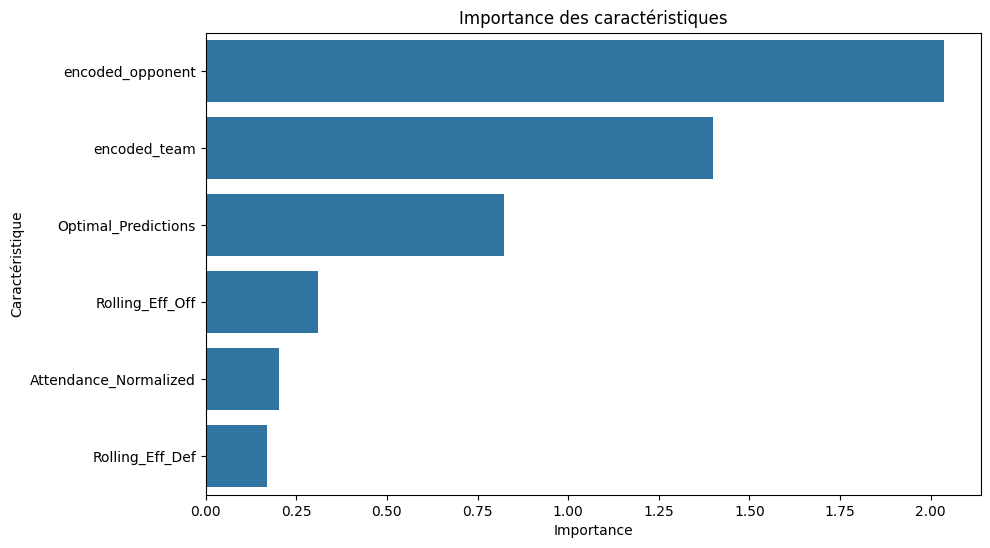

In [157]:
import numpy as np
import pandas as pd

# Extraire le modèle de régression logistique depuis le pipeline
logistic_model = best_log_reg_model.named_steps['logisticregression']

# Récupérer les coefficients
coefficients = logistic_model.coef_[0]  # Coefficients pour chaque caractéristique
features = X_train.columns  # Les noms des colonnes d'entrée

# Créer un DataFrame pour afficher l'importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)  # Valeur absolue pour mesurer la force de l'effet
}).sort_values(by='Importance', ascending=False)

# Afficher les résultats
print("Importance des caractéristiques :")
print(importance_df)

# Optionnel : Visualiser l'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importance des caractéristiques')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()


In [159]:
import pickle
with open('model_final.pkl', 'wb') as file:
    pickle.dump(best_log_reg_model, file)
